In [1]:
import time
import numpy as np
import tensorflow.contrib.keras.api.keras.backend as K
from scipy.misc import imsave, imresize
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.contrib.keras.api.keras.applications import vgg19
from tensorflow.contrib.keras.api.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Define constants
CONTENT_IMG_PATH = './images/content.jpg'
STYLE_IMG_PATH = './images/style.jpg'
OUTPUT_PATH = './output/gen_img.jpg'
# Number of iterations to run
ITER = 5
# Weights of losses
CONTENT_WEIGHT = 0.5
STYLE_WEIGHT = 0.5
TV_WEIGHT = 1.0

BASE_HEIGHT = 400

In [3]:
# Define the shape of the output image
h, w = load_img(CONTENT_IMG_PATH).size
img_h = BASE_HEIGHT
img_w = int(h * img_h / w)

In [4]:
def preprocess(img_path):
    # Preprocessing to make the style transfer
    # possible
    img = load_img(img_path)
    img = img_to_array(img)
    # This dimensions are for Tensorflow backend
    img = imresize(img, (img_h, img_w, 3))
    img = img.astype('float64')
    # Add the batch dimension
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [5]:
content_img = preprocess(CONTENT_IMG_PATH)

/home/phucnguyen/miniconda2/envs/phucnguyen/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


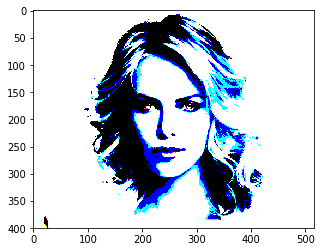

In [6]:
plt.imshow(content_img[0,:])

In [7]:
def deprocess_image(img):
    if K.image_data_format() == 'channels_first':
        # For Theano
        img = img.reshape((3, img_h, img_w))
        img = img.transpose((1, 2, 0))
    else:
        img = img.reshape((img_h, img_w, 3))
    # Remove zero-center by mean pixel
    np.add(img[:, :, 0], 103.939, out=img[:, :, 0], casting='unsafe')
    np.add(img[:, :, 1], 116.779, out=img[:, :, 1], casting='unsafe')
    np.add(img[:, :, 2], 123.68,  out=img[:, :, 2], casting='unsafe')
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [8]:
content_img_deprocess = deprocess_image(content_img)

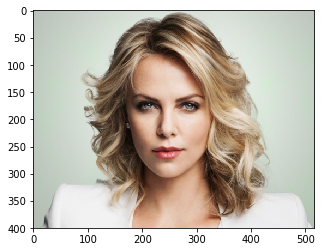

In [9]:
plt.imshow(content_img_deprocess)

In [10]:
# Create Keras variables of input images
content_img = K.variable(preprocess(CONTENT_IMG_PATH))
style_img = K.variable(preprocess(STYLE_IMG_PATH))

/home/phucnguyen/miniconda2/envs/phucnguyen/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


In [11]:
print(K.image_data_format())

channels_last


In [12]:
if K.image_data_format() == 'channels_first':
    gen_img = K.placeholder(shape=(1, 3, img_h, img_w))
else:
    gen_img = K.placeholder(shape=(1, img_h, img_w, 3))

In [13]:
# Create a single tensor containing all three images
input_tensor = K.concatenate([content_img, style_img, gen_img], axis=0)

In [14]:
# Create a vgg19 model by running the input tensor though the vgg19 convolutional
# neural network, excluding the fully connected layers
model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [15]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (3, 400, 517, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 400, 517, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 400, 517, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 200, 258, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 200, 258, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 200, 258, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 100, 129, 128)        0         
__________

In [16]:
# Create an output dictionary
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [17]:
print(outputs_dict)

{'block4_conv3': <tf.Tensor 'block4_conv3/Relu:0' shape=(3, 50, 64, 512) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 129, 128) dtype=float32>, 'block5_conv4': <tf.Tensor 'block5_conv4/Relu:0' shape=(3, 25, 32, 512) dtype=float32>, 'block5_pool': <tf.Tensor 'block5_pool/MaxPool:0' shape=(3, 12, 16, 512) dtype=float32>, 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 129, 256) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 258, 64) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 129, 256) dtype=float32>, 'block5_conv1': <tf.Tensor 'block5_conv1/Relu:0' shape=(3, 25, 32, 512) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 129, 256) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 129, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 50, 64, 256) dtype=float32>, 'block4_conv1': 

In [18]:
# Compute gram matrix for computing style loss
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # Dot product of the flattened feature map and the transpose of the
    # flattened feature map
    gram = K.dot(features, K.transpose(features))
    return gram

In [19]:
# Compute style loss
def compute_style_loss(style, gen):
    style_gram_matrix = gram_matrix(style)
    gen_gram_matrix = gram_matrix(gen)
    return K.sum(K.square(style_gram_matrix - gen_gram_matrix))

In [20]:
# Compute content loss
def compute_content_loss(content, gen):
    return K.sum(K.square(content - gen))

In [21]:
# Compute total variation loss
def compute_total_varianation_loss(x):
    if (K.image_data_format() == 'channels_first'):
        height = x.shape[2]
        width  = x.shape[3]
        a = K.square(x[:, :, :height - 1, :width - 1] - x[:, :, 1:, :width - 1])
        b = K.square(x[:, :, :height - 1, :width - 1] - x[:, :, :height - 1, 1:])
    else:
        height = x.shape[1]
        width = x.shape[2]
        a = K.square(x[:, :height - 1, :width - 1, :] - x[:, 1:, :width - 1, :])
        b = K.square(x[:, :height - 1, :width - 1, :] - x[:, :height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [22]:
# Choose a feature layer in network for compute content loss
content_loss = 0
content_loss_feature_layer_names = ['block5_conv2', 'block5_conv3', 'block5_conv4']
for name in content_loss_feature_layer_names:
    content_loss_feature_layer = outputs_dict[name]
    content_img_feature_layer = content_loss_feature_layer[0, :, :, :]
    gen_img_feature_layer = content_loss_feature_layer[2, :, :, :]
    content_loss = content_loss + compute_content_loss(content_img_feature_layer, gen_img_feature_layer)

content_loss = content_loss / len(content_loss_feature_layer_names)

# Choose a list of feature layers in netwrok for compute style_loss
style_loss = 0
style_loss_feature_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
for name in style_loss_feature_layer_names:
    style_loss_feature_layer = outputs_dict[name]
    style_img_feature_layer = style_loss_feature_layer[1, :, :, :]
    gen_img_feature_layer_style = style_loss_feature_layer[2, :, :, :]
    style_loss = style_loss + compute_style_loss(style_img_feature_layer, gen_img_feature_layer_style)
#Devide style loss to number of layers
style_loss = style_loss / len(style_loss_feature_layer_names)

loss = CONTENT_WEIGHT * content_loss + STYLE_WEIGHT * style_loss + TV_WEIGHT * compute_total_varianation_loss(gen_img)

In [23]:
print(loss)

Tensor("add_10:0", shape=(), dtype=float32)


In [24]:
# Calculate gradients
grads = K.gradients(loss, gen_img)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

# Define a Keras function
f_output = K.function([gen_img], outputs)

In [25]:
print(f_output)

In [26]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_h, img_w))
    else:
        x = x.reshape((1, img_h, img_w, 3))
    outs = f_output([x])
    loss_value = outs[0]
    if (len(outs[1:]) == 1):
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [27]:
#Wrap loss and grad in a class to use L-BFGS optimizer
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_value = grad_value
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_values

In [28]:
# function to draw image
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")
    
    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [29]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(Image.fromarray(image))

/home/phucnguyen/miniconda2/envs/phucnguyen/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Step 0
    loss: 3.2802097628325085e+19
Time: 67.23993229866028


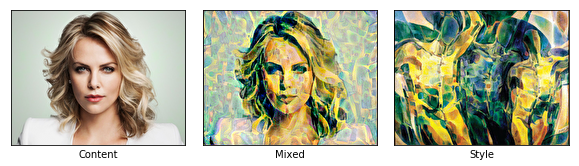

Step 1
    loss: 4.145546744417799e+19
Time: 64.62690019607544


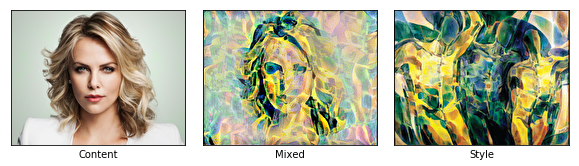

Step 2
    loss: 5.944729078091848e+19
Time: 65.69659852981567


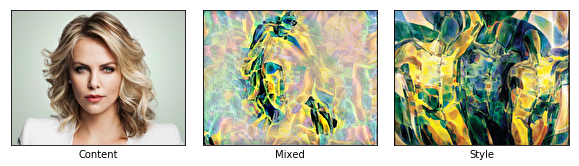

Step 3
    loss: 5.560564553198076e+19
Time: 64.74783992767334


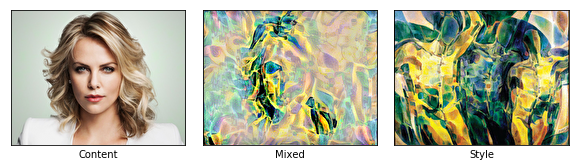

Step 4
    loss: 5.6926875878521045e+19
Time: 63.54038071632385


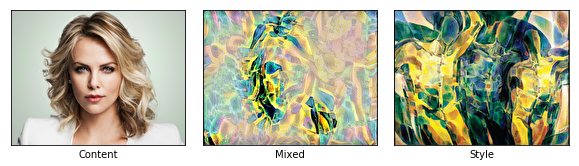

Final image: 


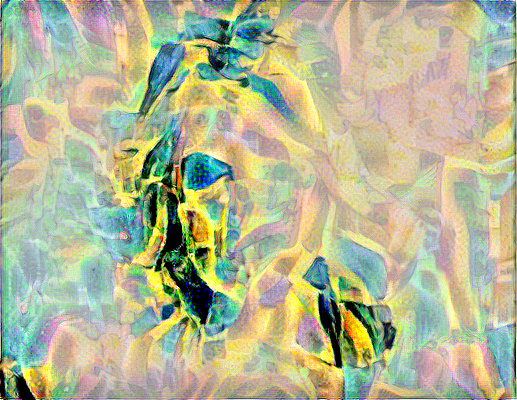

In [30]:
evaluator = Evaluator()

content_img = deprocess_image(preprocess(CONTENT_IMG_PATH))
style_img = deprocess_image(preprocess(STYLE_IMG_PATH))

# Run L-BFGS optimizer
x = preprocess(CONTENT_IMG_PATH)
for i in range(ITER):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=300)
    print('    loss: {}'.format(min_val))
    img = deprocess_image(x)
    print('Time: {}'.format(time.time() - start_time))
    plot_images(content_image=content_img,
                        style_image=style_img,
                        mixed_image=img)

print('Final image: ')
plot_image_big(img)